In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
module = fc.eightb.preselection.t8btag_minmass
bkg = ObjIter([Tree(module.Run2_UL18.QCD_B_List)])

100%|██████████| 16/16 [00:06<00:00,  2.65it/s]


In [3]:
from utils.FeynNet.Feynman import Feynman

diagram = Feynman('x').decays(
    Feynman('y').decays(
        Feynman('h').decays('j','j'),
        Feynman('h').decays('j','j'),
    ),
    Feynman('y').decays(
        Feynman('h').decays('j','j'),
        Feynman('h').decays('j','j'),
    ),
).build_diagram()

product_permutations = {
    typeid: parts[0].get_product_permutations(j=8)
    for typeid, parts in diagram.get_internalstate_types().items()
}

4
4
4


In [4]:
h_j_permutations = product_permutations['h']['j']
y_h_permutations = product_permutations['y']['h']
x_y_permutations = product_permutations['x']['y']
x_h_permutations = y_h_permutations[x_y_permutations].reshape(-1, 4)

In [37]:
@cache_variable
def get_x_4h_m(tree):
    jet_p4 = build_p4(tree, 'jet')
    j1_p4 = jet_p4[:, h_j_permutations[:,0]]
    j2_p4 = jet_p4[:, h_j_permutations[:,1]]
    h_p4 = j1_p4 + j2_p4
    x_4h_m = np.stack([ h_p4.m[:,perm] for perm in x_h_permutations.T ], axis=1)
    x_4h_pt = np.stack([ h_p4.pt[:,perm] for perm in x_h_permutations.T ], axis=1)

    x_4h_order = np.argsort(-x_4h_pt, axis=1)
    x_4h_m = np.take_along_axis(x_4h_m, x_4h_order, axis=1)

    return x_4h_m

@cache_variable
def get_x_4h_pt(tree):
    jet_p4 = build_p4(tree, 'jet')
    j1_p4 = jet_p4[:, h_j_permutations[:,0]]
    j2_p4 = jet_p4[:, h_j_permutations[:,1]]
    h_p4 = j1_p4 + j2_p4
    x_4h_pt = np.stack([ h_p4.pt[:,perm] for perm in x_h_permutations.T ], axis=1)

    x_4h_order = np.argsort(-x_4h_pt, axis=1)
    x_4h_pt = np.take_along_axis(x_4h_pt, x_4h_order, axis=1)

    return x_4h_pt

In [50]:
def load_ranker(tree, ranker=None):
    x_4h_m = ak.to_numpy(get_x_4h_m(tree))
    x_4h_pt = ak.to_numpy(get_x_4h_pt(tree))

    if ranker is None:
        ranker = lambda x, y : np.mean(x, axis=1)
    ranker = ranker(x_4h_m, x_4h_pt)
    

    selected_arg = np.argmax(ranker, axis=1)
    selected_hm = np.stack([ m[np.arange(len(tree)), selected_arg] for m in x_4h_m.transpose(1,0,2) ], axis=1)
    selected_pt = np.stack([ m[np.arange(len(tree)), selected_arg] for m in x_4h_pt.transpose(1,0,2) ], axis=1)

    return selected_hm, selected_pt

In [51]:

x = np.linspace(0,500,30)
x2 = np.linspace(0,500,30)

x, x2 = np.meshgrid(x, x2)

In [53]:
x.shape

(30, 30)

In [108]:
normalize = lambda x : (x - np.min(x)) / (np.max(x) - np.min(x))
def plot_ranker(tree, ranker=None, figax=None):
    fig, ax = get_figax(figax)
    for a in ax.flatten():
        a.ex = getattr(a,'ex',a.twinx())

    selected_hm, selected_pt = load_ranker(tree, ranker=ranker)
    
    x = np.linspace(0,500,30)
    x2 = np.linspace(0,500,30)

    X, X2 = np.meshgrid(x, x2)
    Y = ak.to_numpy(ranker(X.reshape(-1,1), X2.reshape(-1,1))).reshape(30, 30)

    histo_m = Histo.from_array(selected_hm[:,0], bins=(0,500,30), weights=tree.scale, label=repr(ranker), histtype='step', linewidth=2, color=None, efficiency=True)
    ylim=(0, ak.max(histo_m.histo))
    ylim=(ylim[0], ylim[1] + 0.5*(ylim[1]-ylim[0]))
    plot_histo(histo_m, figax=(fig, ax[0]), legend=True, ylim=ylim)

    y1 = Y.mean(axis=0)
    y1 = normalize(y1)
    ylim=(0, 1.5)
    graph_array(x, y1, g_color=histo_m.kwargs['color'], g_linestyle='--', ylabel='rank score', ylim=ylim, figax=(fig, ax[0].ex))
    ax[0].ex.get_yaxis().set_visible(False)

    histo_pt = Histo.from_array(selected_pt[:,0], bins=(0,500,30), weights=tree.scale, label=repr(ranker), histtype='step', linewidth=2, color=None, efficiency=True)
    ylim=(0, ak.max(histo_pt.histo))
    ylim=(ylim[0], ylim[1] + 0.5*(ylim[1]-ylim[0]))
    plot_histo(histo_pt, figax=(fig, ax[1]), legend=True, ylim=ylim)

    y2 = Y.mean(axis=1)
    y2 = normalize(y2)
    ylim=(0, 1.5)
    graph_array(x2, y2, g_color=histo_pt.kwargs['color'], g_linestyle='--', ylabel='rank score', ylim=ylim, figax=(fig, ax[1].ex))
    ax[1].ex.get_yaxis().set_visible(False)


    histo_e = Histo.from_array(np.sqrt(selected_hm[:,0]**2 + selected_pt[:,0]**2), bins=(0,500,30), weights=tree.scale, label=repr(ranker), histtype='step', linewidth=2, color=None, efficiency=True)
    ylim=(0, ak.max(histo_e.histo))
    ylim=(ylim[0], ylim[1] + 0.5*(ylim[1]-ylim[0]))
    plot_histo(histo_e, figax=(fig, ax[2]), legend=True, ylim=ylim)
    
    E = np.sqrt(X**2 + X2**2)
    e = np.unique(E)
    e.sort()
    y3 = np.array([ Y[E==e_i].mean() for e_i in e ])
    y3 = normalize(y3)
    ylim=(0, 1.5)
    graph_array(e, y3, g_color=histo_pt.kwargs['color'], g_linestyle='--', ylabel='rank score', ylim=ylim, figax=(fig, ax[2].ex))
    ax[2].ex.get_yaxis().set_visible(False)

In [115]:
class piecewise:
    def __init__(self, a=1, b=1, c=1):
        self.a = a
        self.b = b
        self.c = c
    def __repr__(self):
        return 'piecewise(a={}, b={}, c={})'.format(self.a, self.b, self.c)
    def __call__(self, x, y):
        # x=y
        x = np.sqrt(x**2 + y**2)
        x = (x - self.a)
        x = ak.where(x < 0, x/self.b, x/self.c)
        return ak.sum(x, axis=1)

[None]

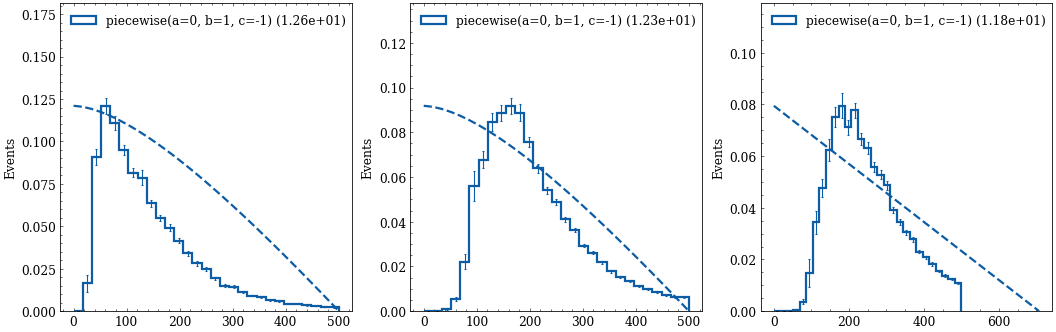

In [117]:
figax = study.get_figax(nvar=3, dim=-1)
bkg.apply(lambda t : plot_ranker(t, ranker=piecewise(a=0, b=1, c=-1), figax=figax))

[None]

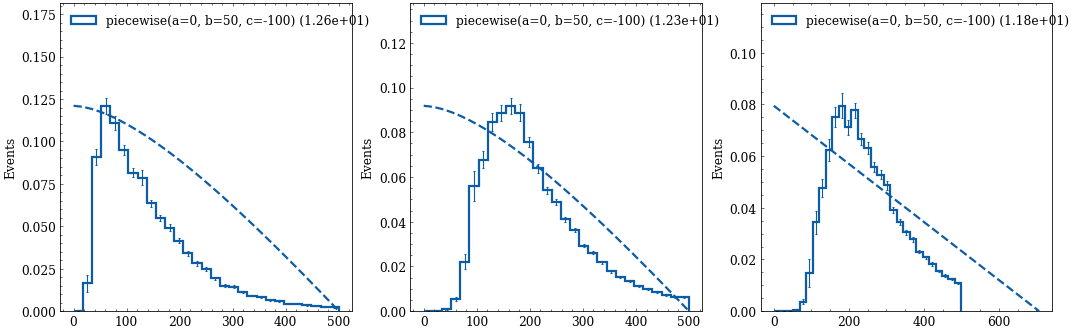

In [116]:
figax = study.get_figax(nvar=3, dim=-1)
bkg.apply(lambda t : plot_ranker(t, ranker=piecewise(a=0, b=50, c=-100), figax=figax))